# PREDICCIÓN DE LAS ACCIONES DE APPLE EMPLEANDO REDES RECURRENTES



In [1]:
import cv2
import pandas as pd
import tarfile
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import re
import glob
from sklearn.preprocessing import MinMaxScaler

# Preparacion de los datos

In [2]:
data_path = "/content/drive/MyDrive/DIPLOMADO INTELIGENCIA ARTIFICIAL/TAREAS/9. RETOS/3. Prediccion de la bolsa/DATA/AAPL_2006-01-01_to_2018-01-01.csv"
DATA = pd.read_csv(data_path)

DATA['Date'] = pd.to_datetime(DATA.Date,format='%Y-%m-%d')
DATA.index = DATA['Date']
DATA = DATA.sort_index(ascending=True, axis=0)

In [3]:
DATA

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...,...
2017-12-22,2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
2017-12-26,2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
2017-12-27,2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL


In [4]:
DATA.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,64.673309,65.256833,64.033445,64.662892,1.311457e+08
std,44.524927,44.811772,44.230829,44.536448,1.018560e+08
min,7.390000,7.560000,7.170000,7.240000,1.147592e+07
25%,23.425000,23.805000,23.015000,23.420000,5.292889e+07
50%,57.860000,58.460000,57.320000,57.920000,1.066271e+08
75%,99.165000,100.275000,98.385000,99.480000,1.798977e+08
max,175.110000,177.200000,174.860000,176.420000,8.432640e+08


Visuazlizacion de los datos de cierre, los cuales van a ser la variable a estimar

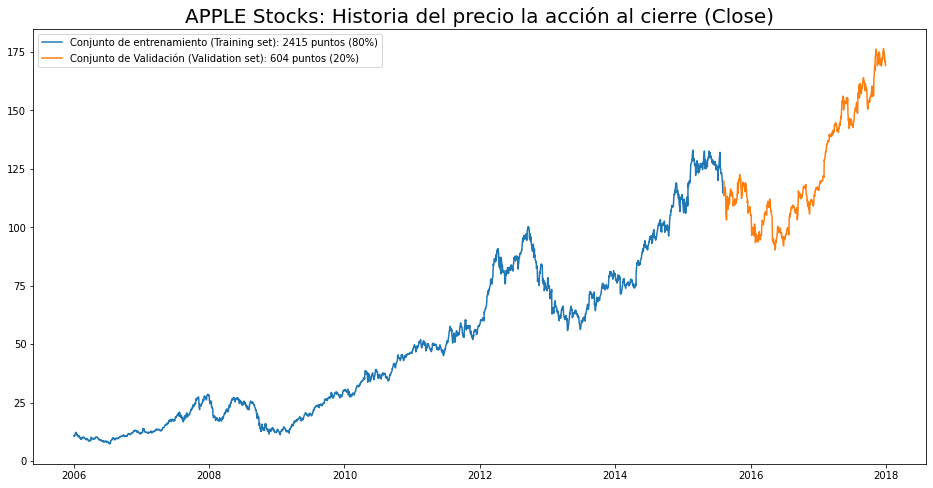

In [5]:
plt.figure(figsize=(16,8))
plt.plot(DATA['Close'][:2415], label='Conjunto de entrenamiento (Training set): 2415 puntos (80%)')
plt.plot(DATA['Close'][2415:], label='Conjunto de Validación (Validation set): 604 puntos (20%)') #248 data
plt.title("APPLE Stocks: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

Prepararion de los vectores que mas adelante se emplearan

In [6]:
open = DATA['Open'].to_numpy().reshape((3019, 1))
close = DATA['Close'].to_numpy().reshape((3019, 1))
high = DATA['High'].to_numpy().reshape((3019, 1))
low = DATA['Low'].to_numpy().reshape((3019, 1))
volume = DATA['Volume'].to_numpy().reshape((3019, 1))

In [7]:
close.shape

(3019, 1)

Normalizado de los datos

In [8]:
scaler_open = MinMaxScaler(feature_range=(-1, 1))
scaler_close = MinMaxScaler(feature_range=(-1, 1))
scaler_high = MinMaxScaler(feature_range=(-1, 1))
scaler_low = MinMaxScaler(feature_range=(-1, 1))
scaler_volume = MinMaxScaler(feature_range=(-1, 1))

scaled_open = scaler_open.fit_transform(open)
scaled_close = scaler_close.fit_transform(close)
scaled_high = scaler_high.fit_transform(high)
scaled_low = scaler_low.fit_transform(low)
scaled_volume = scaler_volume.fit_transform(volume)

## Creacion de los datos de entrenamiento y prueba 
### entrada = close
### salida = close
### ventana de tiempo = 60
### dias = 15

In [9]:
# tamaños para entrenamiento y validación
len_train = 2415 # 80%
len_valid = 604 # 20%
len_data = len_train + len_valid
# 
# Longitud de las tiras de datos para hacer las predicciones
time_step = 60
# días hasta predecir
days = 15
#
# crea datos de entrenamiento
x_train, y_train = [], []
#
for i in range(time_step ,len_train ):
    # x: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_train.append(scaled_close[i-time_step :i,0])
    # y: el siguiente dato
    y_train.append(scaled_close[i+days,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Datos de entrenamiento:")
print(x_train.shape)
print(y_train.shape)


x_test = []
y_test = []

for i in range(len_train,len_data):

    x_test.append(scaled_close[i-time_step - days:i - days,0])
    y_test.append(scaled_close[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))


print("Datos de prueba:")
print(x_test.shape)
print(y_test.shape)



Datos de entrenamiento:
(2355, 60, 1)
(2355, 1)
Datos de prueba:
(604, 60, 1)
(604, 1)


# Creacion de los modelos

In [12]:
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import MeanSquaredError

# MODELO MK01

Model: "regressor_model_mk01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 60, 1)]           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 60, 1)             0         
_________________________________________________________________
GRU_1 (GRU)                  (None, 60, 70)            15330     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 60, 70)            0         
_________________________________________________________________
GRU_2 (GRU)                  (None, 70)                29820     
_________________________________________________________________
Output (Dense)               (None, 1)                 71        
Total params: 45,221
Trainable params: 45,221
Non-trainable params: 0
__________________________________________

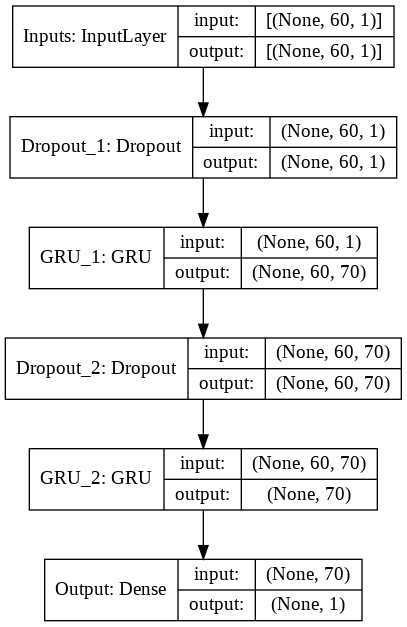

In [245]:
units = 70
input_shape = (x_train.shape[1],1)

inputs = Input(shape= input_shape, name='Inputs')
regresor_layers = inputs
dropout_rate = 0

regresor_layers = Dropout(dropout_rate, name='Dropout_1')(regresor_layers)
regresor_layers = GRU(units=units, return_sequences=True, name='GRU_1')(regresor_layers)
regresor_layers = Dropout(dropout_rate, name='Dropout_2')(regresor_layers)
regresor_layers = GRU(units=units, name='GRU_2')(regresor_layers)
regresor_layers = Dense(1, activation='tanh', name='Output')(regresor_layers)


regressor_model_mk01 = Model(inputs, regresor_layers, name ='regressor_model_mk01')

regressor_model_mk01.summary()
plot_model(regressor_model_mk01, to_file='./regressor_model_mk01.png',show_shapes=True)

In [246]:
regressor_model_mk01.compile(loss='mse', optimizer='adam')

In [247]:
history = regressor_model_mk01.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=5,batch_size=32)

Epoch 1/5
74/74 [==============================] - 4s 18ms/step - loss: 0.0896 - val_loss: 0.0122
Epoch 2/5
74/74 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0158
Epoch 3/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0036 - val_loss: 0.0298
Epoch 4/5
74/74 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0205
Epoch 5/5
74/74 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0255


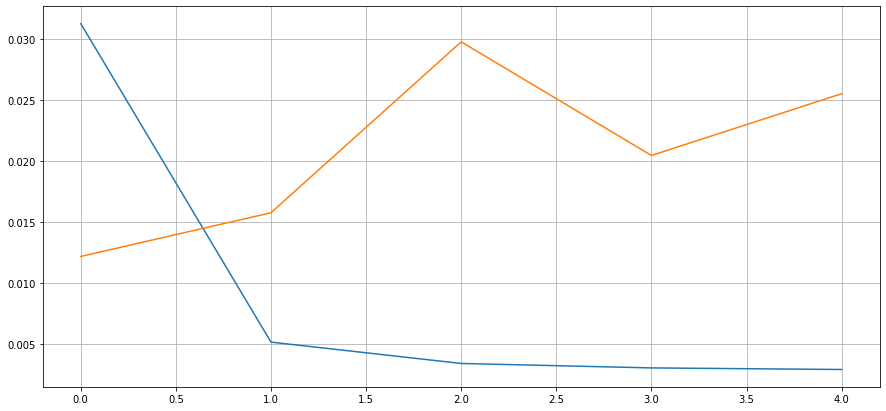

In [248]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

### Prueba del modelo

In [254]:
prediction = regressor_model_mk01.predict(x_test)
prediction = scaler_close.inverse_transform(prediction)

In [255]:
def plot_prediction(real, prediccion):
    plt.figure(figsize=(15,7))
    plt.plot(real,color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

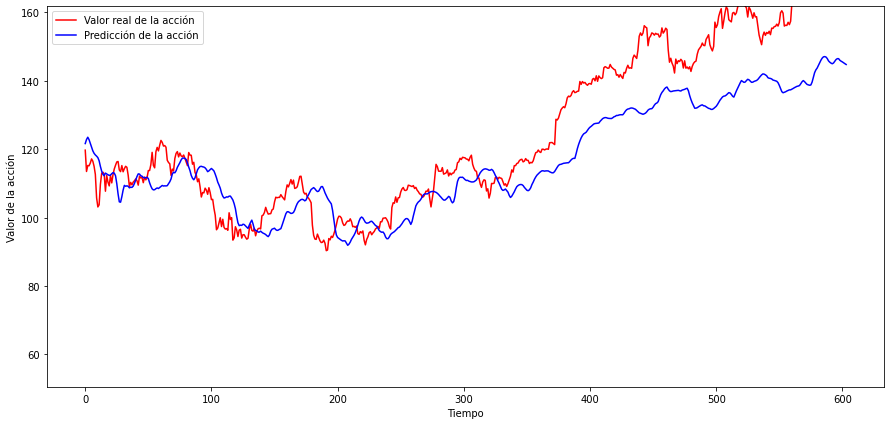

In [256]:
set_validation = close[len_data-len_valid:]
plot_prediction(scaler_close.inverse_transform(y_test) ,prediction)

In [370]:
errors = scaler_close.inverse_transform(y_test) - prediction

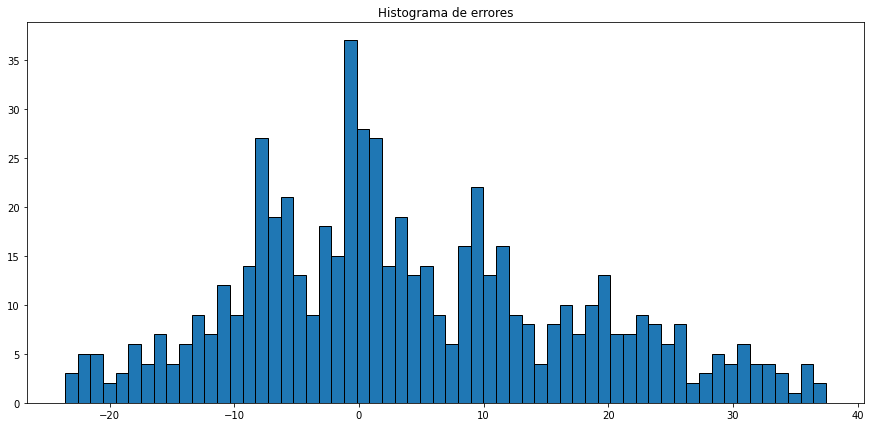

In [231]:
plt.figure(figsize=(15,7))
plt.hist(errors, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
plt.title('Histograma de errores')
plt.show()

## Estimacion de intervalos de confianza

Introducir drop-out al modelo ya entrenado, y ver como se comporta

https://medium.com/hal24k-techblog/how-to-generate-neural-network-confidence-intervals-with-keras-e4c0b78ebbdf (Actualizado a TF 2.X)

In [232]:
from keras.models import Sequential
from keras import backend as K
from tensorflow.python.keras.backend import eager_learning_phase_scope


def create_dropout_predict_function(model, dropout):
    """
    Crea una funcion de keras para predecir un modelo con dropout
    model : modelo entrenado
    dropout : cantidad de dropout que se le aplicara a todas las capas
    
    Returns
    predict_with_dropout : una funcion para ahcer prediccion con dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 

    predict_with_dropout = K.function(model_dropout.inputs, model_dropout.outputs)
    
    return predict_with_dropout

In [448]:
model = regressor_model_mk01

dropout = 0.1 #Ajustado manualmente
num_iter = 50
num_samples = x_test.shape[0]

predict_with_dropout = create_dropout_predict_function(model, dropout)

predictions_dropout = np.zeros((num_samples, num_iter))


# Se engaña al sistema para que aplique el dropout como si estuviera entrenando
with eager_learning_phase_scope(value=1):
  for i in range(num_iter):
      predictions_dropout[:,i] = predict_with_dropout(x_test)[0].reshape(-1)


Histograma de errores con el dropout de 0.1

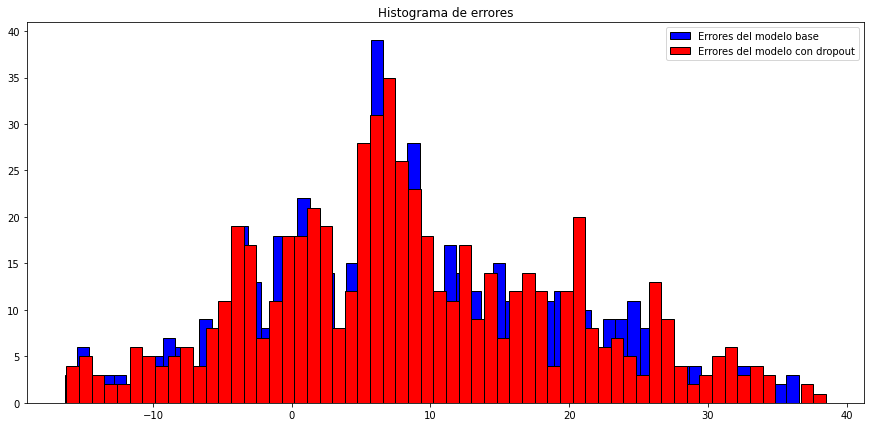

In [449]:
dropout_mean_pred = np.mean(predictions_dropout, axis = 1)
dropout_mean_pred = scaler_close.inverse_transform(dropout_mean_pred.reshape(dropout_mean_pred.shape[0],1))
errors_dropout = scaler_close.inverse_transform(y_test) - dropout_mean_pred

plt.figure(figsize=(15,7))

plt.hist(errors,color = 'blue', bins=60, alpha=1, edgecolor = 'black',  linewidth=1, label='Errores del modelo base')
plt.hist(errors_dropout,color = 'red', bins=60, alpha=1, edgecolor = 'black',  linewidth=1, label='Errores del modelo con dropout')

plt.legend(loc='upper right')
plt.title('Histograma de errores')
plt.show()

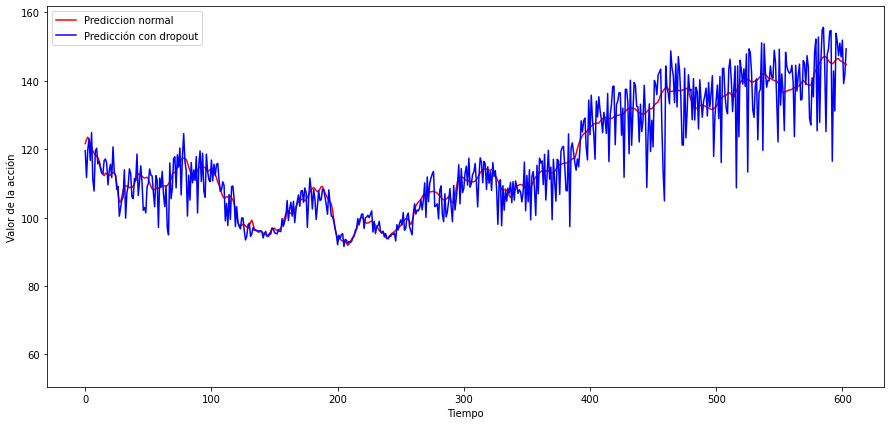

In [450]:
# Se engaña al sistema para que aplique el dropout como si estuviera entrenando
with eager_learning_phase_scope(value=1):
  prediction_dropout = predict_with_dropout(x_test)[0]
  prediction_dropout = scaler_close.inverse_transform(prediction_dropout)

plt.figure(figsize=(15,7))
plt.plot(prediction,color='red', label='Prediccion normal')
plt.plot(prediction_dropout, color='blue', label='Predicción con dropout')
plt.ylim(1.1 * np.min(prediction)/2, 1.1 * np.max(prediction))
plt.xlabel('Tiempo')
plt.ylabel('Valor de la acción')
plt.legend()
plt.show()

Se estiman los margenes de error para un intervalo de confianza determinado al 80%

In [451]:
intervalo_de_confianza = 0.8
lower_lim = np.quantile(predictions_dropout, 0.5-intervalo_de_confianza/2, axis=1)
upper_lim = np.quantile(predictions_dropout, 0.5+intervalo_de_confianza/2, axis=1)

lower_lim = scaler_close.inverse_transform(lower_lim.reshape(lower_lim.shape[0],1))
upper_lim = scaler_close.inverse_transform(upper_lim.reshape(upper_lim.shape[0],1))

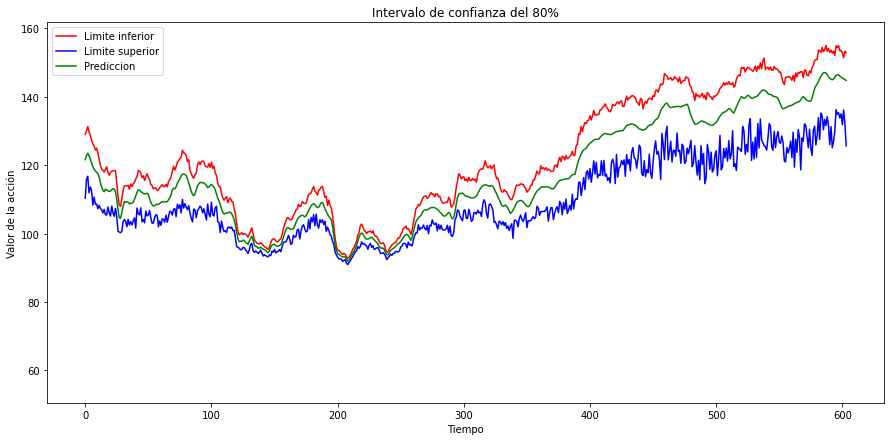

In [452]:
plt.figure(figsize=(15,7))
plt.plot(upper_lim,color='red', label='Limite inferior')
plt.plot(lower_lim, color='blue', label='Limite superior')
plt.plot(prediction, color='green', label='Prediccion')
plt.ylim(1.1 * np.min(prediction)/2, 1.1 * np.max(prediction))
plt.xlabel('Tiempo')
plt.ylabel('Valor de la acción')
plt.title('Intervalo de confianza del 80%')
plt.legend()
plt.show()

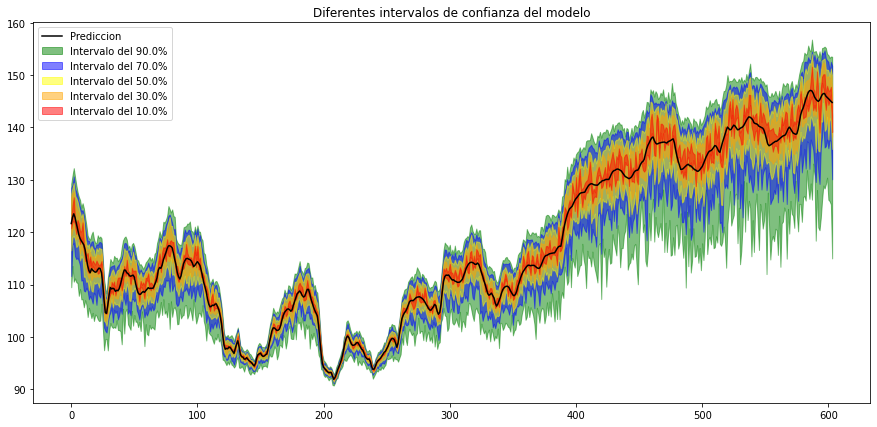

In [506]:
plt.figure(figsize=(15,7))

intervalos_de_confianza = [0.1, 0.3, 0.5, 0.7, 0.9]
intervalos_de_confianza = list(reversed(intervalos_de_confianza))

colores = ['red', 'orange', 'yellow', 'blue', 'green']
colores = list(reversed(colores))

x = np.arange(0,x_test.shape[0],1)

plt.plot(prediction, color='black', label='Prediccion')

for i in range(len(intervalos_de_confianza)):

  intervalo_de_confianza = intervalos_de_confianza[i]
  lower_lim = np.quantile(predictions_dropout, 0.5-intervalo_de_confianza/2, axis=1)
  upper_lim = np.quantile(predictions_dropout, 0.5+intervalo_de_confianza/2, axis=1)

  lower_lim = scaler_close.inverse_transform(lower_lim.reshape(lower_lim.shape[0],1))
  upper_lim = scaler_close.inverse_transform(upper_lim.reshape(upper_lim.shape[0],1))


  plt.fill_between(x, lower_lim.reshape(lower_lim.shape[0]), upper_lim.reshape(upper_lim.shape[0]), alpha=0.5, color=colores[i], label='Intervalo del ' + str(intervalos_de_confianza[i]*100) + '%' )
plt.title('Diferentes intervalos de confianza del modelo')
plt.legend()
plt.show()